# Modèle mono vue Recto Verso

Installation des packages

In [40]:
from dotenv import load_dotenv, find_dotenv
import numpy as np
import datetime, os
import tarfile
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, array_to_img, img_to_array, load_img, image_dataset_from_directory
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import datetime

In [41]:
load_dotenv(find_dotenv())
PATH_TO_SMALL_ROI_TYP_FOR_KERAS = os.environ.get("PATH_TO_SMALL_ROI_TYP_FOR_KERAS")
PATH_TO_SMALL_ROI_TYP_FOR_KERAS

path = join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS, 'RECTO')
path

'/Users/perraudlouis/Documents/Cours3A/PFE/Images_ROI_pour_ENSAI/SMALL_ROI_TYP_FOR_KERAS/RECTO'

In [42]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
BATCH_SIZE = 32
CLASSES = 8

In [43]:
train  = image_dataset_from_directory(path,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='training',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

val = image_dataset_from_directory(path,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='validation',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

Found 2301 files belonging to 7 classes.
Using 1841 files for training.
Found 2301 files belonging to 7 classes.
Using 460 files for validation.


In [44]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.prefetch(buffer_size=AUTOTUNE)
# validationR = validationR.prefetch(buffer_size=AUTOTUNE)

In [45]:
# Creation du modèle de base à partir du modèle pré-entraîné EffB3
base_model = tf.keras.applications.EfficientNetB5(input_shape=INPUT_SHAPE,
include_top=False,
weights='imagenet')

In [46]:
base_model.trainable = False

In [47]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
inputs1 = tf.keras.Input(shape=(224, 224, 3))
x1 = preprocess_input(inputs1)
x1 = base_model(x1, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)

x = tf.keras.layers.Dense(CLASSES, activation = 'softmax')(x1)
outputs = x
model = tf.keras.Model(inputs=inputs1, outputs=outputs)

In [48]:
base_learning_rate = 10**(-3)
model.compile(optimizer=tf.keras.optimizers.
Adam(learning_rate=base_learning_rate),
loss="sparse_categorical_crossentropy",
metrics = ['accuracy'])

In [49]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 28,529,919
Trainable params: 16,392
Non-trainable params: 28,513,527
__________________________________________

In [50]:
base_path = r"/Users/perraudlouis/Documents/Cours3A/PFE/Code/pfe-deep-learning-maladies-plantes"

In [51]:
path_to_save = os.path.join(base_path,"save_models/mono_view/",f'ECHANT_recto_EfficientNetB5_batch_size_{BATCH_SIZE}.h5')

In [ ]:
initial_epochs = 30
history = model.fit(train,
epochs=initial_epochs,
validation_data=val
)

In [52]:
model.save_weights(path_to_save,save_format='h5')

In [56]:
model.load_weights(path_to_save)

### Traitements pour double entrée

In [54]:
X_train = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_train_tensor = tf.zeros(shape=(32,),dtype=tf.int32)
for recto in train:
    X_train = tf.concat([X_train,recto[0]],0)
    y_train_tensor = tf.concat([y_train_tensor,recto[1]],0)

X_test = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_test_tensor = tf.zeros(shape=(32,),dtype=tf.int32)
for recto in val:
    X_test = tf.concat([X_test,recto[0]],0)
    y_test_tensor = tf.concat([y_test_tensor,recto[1]],0)




### Plot training

In [57]:
model.evaluate(x=X_test,y=y_test_tensor,batch_size=BATCH_SIZE)

16/16 [==============================] - 21s 1s/step - loss: 0.3765 - accuracy: 0.8923


[0.37645423412323, 0.892276406288147]

16/16 [==============================] - 23s 1s/step


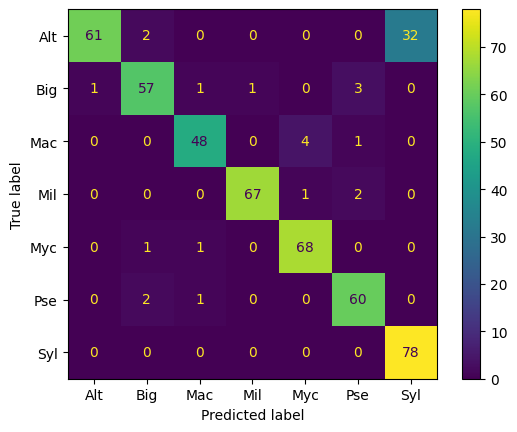

Accuracy : 0.8922764227642277
Balanced Accuracy : 0.9047828466043816


In [58]:
y_pred=np.argmax(model.predict(x=X_test),axis=-1)
y_obs=y_test_tensor
# let's use sklearn
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
le = preprocessing.LabelEncoder()
le.fit(lb)
y_pred=le.inverse_transform(y_pred)
y_obs=le.inverse_transform(y_obs)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_obs,
y_pred,labels=lb),display_labels=lb)
disp.plot()
plt.show()
print("Accuracy : "+str(accuracy_score(y_obs, y_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(y_obs, y_pred)))